In [42]:
import glob

In [74]:
import os
os.getcwd()

'/Users/Ji/Documents/Courses/NLP/Assignments'

In [44]:
train_neg_files = glob.glob("Assignment_1/aclImdb/train/neg/*.txt")
train_pos_files = glob.glob("Assignment_1/aclImdb/train/pos/*.txt")
test_neg_files = glob.glob("Assignment_1/aclImdb/test/neg/*.txt")
test_pos_files = glob.glob("Assignment_1/aclImdb/test/pos/*.txt")
print(len(train_neg_files), len(train_pos_files), len(test_neg_files), len(test_pos_files))
## wow! clean data!

12500 12500 12500 12500


In [45]:
## read files
train_neg_raw = []
for i in train_neg_files:
    with open(i, 'r') as f:
        train_neg_raw.append(f.read())

train_pos_raw = []
for i in train_pos_files:
    with open(i, 'r') as f:
        train_pos_raw.append(f.read())

test_neg_raw = []
for i in test_neg_files:
    with open(i, 'r') as f:
        test_neg_raw.append(f.read())

test_pos_raw = []
for i in test_pos_files:
    with open(i, 'r') as f:
        test_pos_raw.append(f.read())
        

In [47]:
## combine into training set and test set
from sklearn import model_selection
train_data_all = train_pos_raw + train_neg_raw
train_label_all = np.append(np.ones(12500), np.zeros(12500))
test_data = test_pos_raw + test_neg_raw
test_label = train_label_all

## finding duplicates and removing them
whole, seen, result = train_data_all+test_data, set(), []
for idx, item in enumerate(whole):
    if item not in seen:
        seen.add(item)          # First time seeing the element
    else:
        result.append(idx)      # Already seen, add the index to the result
train_dup_idx = [i for i in result if i < 25000]
test_dup_idx = [i-25000 for i in result if i >= 25000]
print(len(train_dup_idx), len(test_dup_idx))

train_data_all_rmdup = [ item for i,item in enumerate(train_data_all) if i not in train_dup_idx ]
train_label_all_rmdup = [ item for i,item in enumerate(train_label_all) if i not in train_dup_idx ]
test_data_rmdup = [ item for i,item in enumerate(test_data) if i not in test_dup_idx ]
test_label_rmdup = [ item for i,item in enumerate(test_label) if i not in test_dup_idx ]

## data split
import re
for i in range(len(train_data_all_rmdup)):
    train_data_all_rmdup[i] = re.sub("<br /><br />", " ", train_data_all_rmdup[i])
    train_data_all_rmdup[i] = re.sub("\'", "", train_data_all_rmdup[i])
for i in range(len(test_data_rmdup)):
    test_data_rmdup[i] = re.sub("<br /><br />", " ", test_data_rmdup[i])
    test_data_rmdup[i] = re.sub("\'", "", test_data_rmdup[i])

train_data, val_data, train_label, val_label = model_selection.train_test_split(train_data_all_rmdup, train_label_all_rmdup, 
                                                                test_size=0.2, random_state=1)

96 322


In [48]:
# Let's write the tokenization function 

import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# Example
tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
print (tokens)

['apple', 'is', 'looking', 'at', 'buying', 'u.k.', 'startup', 'for', '1', 'billion']


In [49]:
# This is the code cell that tokenizes train/val/test datasets
# However it takes about 15-20 minutes to run it
# For convinience we have provided the preprocessed datasets
# Please see the next code cell
import pickle as pkl

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_data)
# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(test_data_rmdup)
# pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [50]:
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 19923
Val dataset size is 4981
Test dataset size is 24678
Total number of tokens in train dataset is 4727320


# Hyperparameter Tuning
## 1. tokenization schemes

### default scheme vs. removing stopwords, stemming and lemmetization

In [51]:
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from collections import Counter
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer


max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, rm_stopwords = False, lemmatize = False, stem = False):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    if rm_stopwords:
        stop_words = set(stopwords.words('english')) 
        all_tokens = [w for w in all_tokens if not w in stop_words] 
    if lemmatize:
        lmtzr = WordNetLemmatizer()
        all_tokens = [lmtzr.lemmatize(w) for w in all_tokens]
    if stem:
        ps = PorterStemmer()
        all_tokens = [ps.stem(w) for w in all_tokens]
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)
token2id_rmsw, id2token_rmsw = build_vocab(all_train_tokens, rm_stopwords = True)
token2id_prcd, id2token_prcd = build_vocab(all_train_tokens, rm_stopwords = True, lemmatize = True, stem = True)

In [52]:
# Lets check the dictionary by loading random token from it
import random
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))
print ("Token {}; token id {}".format(random_token, token2id["meadows"]))

Token id 2239 ; token asking
Token asking; token id 2239
Token asking; token id 8879


In [53]:
# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id_map = token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id_map[token] if token in token2id_map else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

train_data_indices_rmsw = token2index_dataset(train_data_tokens, token2id_map = token2id_rmsw)
val_data_indices_rmsw = token2index_dataset(val_data_tokens, token2id_map = token2id_rmsw)

train_data_indices_prcd = token2index_dataset(train_data_tokens, token2id_map = token2id_prcd)
val_data_indices_prcd = token2index_dataset(val_data_tokens, token2id_map = token2id_prcd)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def data_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

train_dataset_rmsw = NewsGroupDataset(train_data_indices_rmsw, train_label)
train_loader_rmsw = torch.utils.data.DataLoader(dataset=train_dataset_rmsw, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset_rmsw = NewsGroupDataset(val_data_indices_rmsw, val_label)
val_loader_rmsw = torch.utils.data.DataLoader(dataset=val_dataset_rmsw, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

train_dataset_prcd = NewsGroupDataset(train_data_indices_prcd, train_label)
train_loader_prcd = torch.utils.data.DataLoader(dataset=train_dataset_prcd, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset_prcd = NewsGroupDataset(val_data_indices_prcd, val_label)
val_loader_prcd = torch.utils.data.DataLoader(dataset=val_dataset_prcd, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)



# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    test_loss = []
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, label_batch)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        test_loss.append(loss.data.numpy())
    #print(test_loss)
    return (100 * correct / total), np.mean(test_loss)



Train dataset size is 19923
Val dataset size is 4981
Test dataset size is 24678


### Default tokenization model training & validation

In [67]:
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_df = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_df.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Default tokenization - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.7854213118553162, Val Loss: 2.4459967613220215, Val Acc: 74.98494278257378
Epoch: [1/10], Step: [201/623], Train Loss: 0.6038910746574402, Val Loss: 2.319542169570923, Val Acc: 84.01927323830556
Epoch: [1/10], Step: [301/623], Train Loss: 0.5236561298370361, Val Loss: 2.2879624366760254, Val Acc: 86.10720738807468
Epoch: [1/10], Step: [401/623], Train Loss: 0.47631028294563293, Val Loss: 2.273961067199707, Val Acc: 85.98674964866493
Epoch: [1/10], Step: [501/623], Train Loss: 0.44805431365966797, Val Loss: 2.2669484615325928, Val Acc: 87.25155591246738
Epoch: [1/10], Step: [601/623], Train Loss: 0.42757147550582886, Val Loss: 2.2585885524749756, Val Acc: 87.33186107207388
Epoch: [1/10], Train Acc: 90.05169904130904
Epoch: [2/10], Step: [101/623], Train Loss: 0.20235832035541534, Val Loss: 2.246875762939453, Val Acc: 87.45231881148364
Epoch: [2/10], Step: [201/623], Train Loss: 0.2183261662721634, Val Loss: 2.2417376041412354, Val Acc: 87.39

### Only removing stopwords - model training & validation

In [68]:
emb_dim = 100
model = BagOfWords(len(id2token_rmsw), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_rmsw = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader_rmsw):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader_rmsw, model)
            val_acc_rmsw.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader_rmsw), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader_rmsw, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Tokenization: only removing stopwords - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.7020294666290283, Val Loss: 2.4620540142059326, Val Acc: 65.06725557117045
Epoch: [1/10], Step: [201/623], Train Loss: 0.5776280760765076, Val Loss: 2.3319802284240723, Val Acc: 83.55751857056816
Epoch: [1/10], Step: [301/623], Train Loss: 0.5048703551292419, Val Loss: 2.289166212081909, Val Acc: 85.38446095161615
Epoch: [1/10], Step: [401/623], Train Loss: 0.4653456509113312, Val Loss: 2.2735729217529297, Val Acc: 86.8901826942381
Epoch: [1/10], Step: [501/623], Train Loss: 0.43591198325157166, Val Loss: 2.264702320098877, Val Acc: 86.9704878538446
Epoch: [1/10], Step: [601/623], Train Loss: 0.41777071356773376, Val Loss: 2.26481032371521, Val Acc: 86.78980124472997
Epoch: [1/10], Train Acc: 91.10575716508558
Epoch: [2/10], Step: [101/623], Train Loss: 0.23542645573616028, Val Loss: 2.2481768131256104, Val Acc: 87.79361573981129
Epoch: [2/10], Step: [201/623], Train Loss: 0.22903241217136383, Val Loss: 2.2442705631256104, Val Acc: 87.59285

### Removing stopwords, lemmetization and stemming - model training & validation

In [69]:
emb_dim = 100
model = BagOfWords(len(id2token_prcd), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_prcd = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader_prcd):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader_prcd, model)
            val_acc_prcd.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader_prcd, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Tokenization: removing stopwords, lemmetization and stemming - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.7367023229598999, Val Loss: 2.5087432861328125, Val Acc: 71.0098373820518
Epoch: [1/10], Step: [201/623], Train Loss: 0.6420632004737854, Val Loss: 2.419785737991333, Val Acc: 71.43143946998595
Epoch: [1/10], Step: [301/623], Train Loss: 0.5840003490447998, Val Loss: 2.363603353500366, Val Acc: 78.37783577594861
Epoch: [1/10], Step: [401/623], Train Loss: 0.5463563799858093, Val Loss: 2.3428192138671875, Val Acc: 81.73057618952018
Epoch: [1/10], Step: [501/623], Train Loss: 0.5200263261795044, Val Loss: 2.3371925354003906, Val Acc: 80.96767717325838
Epoch: [1/10], Step: [601/623], Train Loss: 0.5034928321838379, Val Loss: 2.3362293243408203, Val Acc: 80.70668540453724
Epoch: [1/10], Train Acc: 86.72890628921347
Epoch: [2/10], Step: [101/623], Train Loss: 0.32985323667526245, Val Loss: 2.3236608505249023, Val Acc: 79.48203172053805
Epoch: [2/10], Step: [201/623], Train Loss: 0.33238914608955383, Val Loss: 2.310842990875244, Val Acc: 81.18851

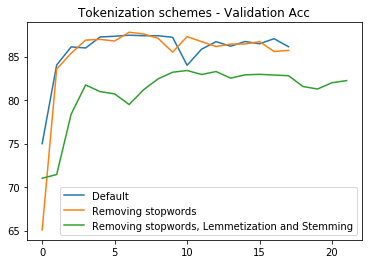

In [167]:
## plotting training curve
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(val_acc_df)
plt.plot(val_acc_rmsw)
plt.plot(val_acc_prcd)
plt.title('Tokenization schemes - Validation Acc')
plt.legend(['Default', 'Removing stopwords', 'Removing stopwords, Lemmetization and Stemming'], loc='lower right')
#plt.show()
plt.savefig('Assignment_1/training_curve_tokenization.jpg')

## It appears that using the default scheme performs almost the same with removing stopwords. Lemmetization and stemming seems an overkill for this task. 

## From now on, removing stopwords will be applied

## 2. N-gram (1, 2, 3, 4)

### a. Unigram

In [92]:
from nltk.util import ngrams

def tokenize_dataset(dataset, n = 1):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        stop_words = set(stopwords.words('english')) 
        tokens = [w for w in tokens if not w in stop_words] 
        if n > 1:
            ngrams_gn = ngrams(tokens, n)
            tokens = []
            for gram in ngrams_gn:
                tokens.append(gram)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_data)
# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
#     if rm_stopwords:
#         stop_words = set(stopwords.words('english')) 
#         all_tokens = [w for w in all_tokens if not w in stop_words] 
#     if lemmatize:
#         lmtzr = WordNetLemmatizer()
#         all_tokens = [lmtzr.lemmatize(w) for w in all_tokens]
#     if stem:
#         ps = PorterStemmer()
#         all_tokens = [ps.stem(w) for w in all_tokens]
#     if n > 1:
#         all_tokens = ngrams(all_tokens, n)
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

train_data_indices = token2index_dataset(train_data_tokens, token2id_map = token2id)
val_data_indices = token2index_dataset(val_data_tokens, token2id_map = token2id)

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_n1 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_n1.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Unigram - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)

del train_data_tokens, all_train_tokens, val_data_tokens

Epoch: [1/10], Step: [101/623], Train Loss: 0.7620635032653809, Val Loss: 2.370851755142212, Val Acc: 80.08432041758682
Epoch: [1/10], Step: [201/623], Train Loss: 0.5616288185119629, Val Loss: 2.279052972793579, Val Acc: 86.36819915679582
Epoch: [1/10], Step: [301/623], Train Loss: 0.48318198323249817, Val Loss: 2.2621326446533203, Val Acc: 86.60911463561534
Epoch: [1/10], Step: [401/623], Train Loss: 0.43653804063796997, Val Loss: 2.246751546859741, Val Acc: 88.35575185705682
Epoch: [1/10], Step: [501/623], Train Loss: 0.4113127589225769, Val Loss: 2.2486064434051514, Val Acc: 87.53262397109015
Epoch: [1/10], Step: [601/623], Train Loss: 0.39562875032424927, Val Loss: 2.256150960922241, Val Acc: 86.9704878538446
Epoch: [1/10], Train Acc: 94.09225518245245
Epoch: [2/10], Step: [101/623], Train Loss: 0.17512089014053345, Val Loss: 2.2260990142822266, Val Acc: 88.69704878538447
Epoch: [2/10], Step: [201/623], Train Loss: 0.17568831145763397, Val Loss: 2.224189043045044, Val Acc: 88.6368

### b. Bigram

In [83]:
def tokenize_dataset(dataset, n = 1):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        stop_words = set(stopwords.words('english')) 
        tokens = [w for w in tokens if not w in stop_words] 
        if n > 1:
            ngrams_gn = ngrams(tokens, n)
            tokens = []
            for gram in ngrams_gn:
                tokens.append(gram)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
# val_data_tokens_n2, _ = tokenize_dataset(val_data, n = 2)
# pkl.dump(val_data_tokens_n2, open("val_data_tokens_n2.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens_n2, all_train_tokens_n2 = tokenize_dataset(train_data, n = 2)
# pkl.dump(train_data_tokens_n2, open("train_data_tokens_n2.p", "wb"))
# pkl.dump(all_train_tokens_n2, open("all_train_tokens_n2.p", "wb"))

train_data_tokens_n2 = pkl.load(open("train_data_tokens_n2.p", "rb"))
all_train_tokens_n2 = pkl.load(open("all_train_tokens_n2.p", "rb"))
val_data_tokens_n2 = pkl.load(open("val_data_tokens_n2.p", "rb"))

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

token2id_n2, id2token_n2 = build_vocab(all_train_tokens_n2)

train_data_indices_n2 = token2index_dataset(train_data_tokens_n2, token2id_map = token2id_n2)
val_data_indices_n2 = token2index_dataset(val_data_tokens_n2, token2id_map = token2id_n2)

train_dataset = NewsGroupDataset(train_data_indices_n2, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_n2, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 100
model = BagOfWords(len(id2token_n2), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_n2 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_n2.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Bigram - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)

del train_data_tokens_n2, all_train_tokens_n2, val_data_tokens_n2

Tokenizing val data
Tokenizing train data
Epoch: [1/10], Step: [101/623], Train Loss: 0.7483088374137878, Val Loss: 2.539362668991089, Val Acc: 71.79281268821522
Epoch: [1/10], Step: [201/623], Train Loss: 0.699461817741394, Val Loss: 2.473186492919922, Val Acc: 70.50793013451114
Epoch: [1/10], Step: [301/623], Train Loss: 0.6441764831542969, Val Loss: 2.420319080352783, Val Acc: 72.33487251555913
Epoch: [1/10], Step: [401/623], Train Loss: 0.5996631979942322, Val Loss: 2.3790340423583984, Val Acc: 77.59486046978519
Epoch: [1/10], Step: [501/623], Train Loss: 0.5659245252609253, Val Loss: 2.3492419719696045, Val Acc: 80.98775346316
Epoch: [1/10], Step: [601/623], Train Loss: 0.5415062308311462, Val Loss: 2.3542051315307617, Val Acc: 77.11302951214616
Epoch: [1/10], Train Acc: 89.00767956633037
Epoch: [2/10], Step: [101/623], Train Loss: 0.3272755444049835, Val Loss: 2.3255040645599365, Val Acc: 80.827143143947
Epoch: [2/10], Step: [201/623], Train Loss: 0.3125482201576233, Val Loss: 2.

### c. Trigram

In [84]:
# val set tokens
print ("Tokenizing val data")
val_data_tokens_n3, _ = tokenize_dataset(val_data, n = 3)
pkl.dump(val_data_tokens_n3, open("val_data_tokens_n3.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens_n3, all_train_tokens_n3 = tokenize_dataset(train_data, n = 3)
pkl.dump(train_data_tokens_n3, open("train_data_tokens_n3.p", "wb"))
pkl.dump(all_train_tokens_n3, open("all_train_tokens_n3.p", "wb"))

train_data_tokens_n3 = pkl.load(open("train_data_tokens_n3.p", "rb"))
all_train_tokens_n3 = pkl.load(open("all_train_tokens_n3.p", "rb"))
val_data_tokens_n3 = pkl.load(open("val_data_tokens_n3.p", "rb"))

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

token2id_n3, id2token_n3 = build_vocab(all_train_tokens_n3)

train_data_indices_n3 = token2index_dataset(train_data_tokens_n3, token2id_map = token2id_n3)
val_data_indices_n3 = token2index_dataset(val_data_tokens_n3, token2id_map = token2id_n3)

train_dataset = NewsGroupDataset(train_data_indices_n3, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_n3, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 100
model = BagOfWords(len(id2token_n3), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_n3 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_n3.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Trigram - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)

del train_data_tokens_n3, all_train_tokens_n3, val_data_tokens_n3

Tokenizing val data
Tokenizing train data
Epoch: [1/10], Step: [101/623], Train Loss: 0.762969970703125, Val Loss: 2.557878017425537, Val Acc: 49.7691226661313
Epoch: [1/10], Step: [201/623], Train Loss: 0.7300273776054382, Val Loss: 2.554076671600342, Val Acc: 51.897209395703676
Epoch: [1/10], Step: [301/623], Train Loss: 0.7226154208183289, Val Loss: 2.547767400741577, Val Acc: 61.413370809074486
Epoch: [1/10], Step: [401/623], Train Loss: 0.7110732793807983, Val Loss: 2.5318849086761475, Val Acc: 56.91628187111022
Epoch: [1/10], Step: [501/623], Train Loss: 0.6981146335601807, Val Loss: 2.524343252182007, Val Acc: 52.35896406344108
Epoch: [1/10], Step: [601/623], Train Loss: 0.6842151284217834, Val Loss: 2.5000407695770264, Val Acc: 59.68680987753463
Epoch: [1/10], Train Acc: 75.10415098127793
Epoch: [2/10], Step: [101/623], Train Loss: 0.5393630862236023, Val Loss: 2.472050905227661, Val Acc: 69.08251355149568
Epoch: [2/10], Step: [201/623], Train Loss: 0.5244731903076172, Val Loss

### d. Four-gram

In [85]:
# val set tokens
print ("Tokenizing val data")
val_data_tokens_n4, _ = tokenize_dataset(val_data, n = 4)
pkl.dump(val_data_tokens_n4, open("val_data_tokens_n4.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens_n4, all_train_tokens_n4 = tokenize_dataset(train_data, n = 4)
pkl.dump(train_data_tokens_n4, open("train_data_tokens_n4.p", "wb"))
pkl.dump(all_train_tokens_n4, open("all_train_tokens_n4.p", "wb"))

train_data_tokens_n4 = pkl.load(open("train_data_tokens_n4.p", "rb"))
all_train_tokens_n4 = pkl.load(open("all_train_tokens_n4.p", "rb"))
val_data_tokens_n4 = pkl.load(open("val_data_tokens_n4.p", "rb"))

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

token2id_n4, id2token_n4 = build_vocab(all_train_tokens_n4)

train_data_indices_n4 = token2index_dataset(train_data_tokens_n4, token2id_map = token2id_n4)
val_data_indices_n4 = token2index_dataset(val_data_tokens_n4, token2id_map = token2id_n4)

train_dataset = NewsGroupDataset(train_data_indices_n4, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices_n4, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 100
model = BagOfWords(len(id2token_n4), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_n4 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_n4.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Fourgram - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)

del train_data_tokens_n4, all_train_tokens_n4, val_data_tokens_n4

Tokenizing val data
Tokenizing train data
Epoch: [1/10], Step: [101/623], Train Loss: 0.7611814737319946, Val Loss: 2.558610677719116, Val Acc: 49.74904637622967
Epoch: [1/10], Step: [201/623], Train Loss: 0.7389953136444092, Val Loss: 2.5604302883148193, Val Acc: 50.2308773338687
Epoch: [1/10], Step: [301/623], Train Loss: 0.7323024272918701, Val Loss: 2.5578179359436035, Val Acc: 50.29110620357358
Epoch: [1/10], Step: [401/623], Train Loss: 0.72617506980896, Val Loss: 2.557344913482666, Val Acc: 50.13049588436057
Epoch: [1/10], Step: [501/623], Train Loss: 0.7236428260803223, Val Loss: 2.5577173233032227, Val Acc: 50.351335073278456
Epoch: [1/10], Step: [601/623], Train Loss: 0.720410943031311, Val Loss: 2.559602737426758, Val Acc: 49.7691226661313
Epoch: [1/10], Train Acc: 50.72529237564624
Epoch: [2/10], Step: [101/623], Train Loss: 0.6859458684921265, Val Loss: 2.553286075592041, Val Acc: 51.73659907649066
Epoch: [2/10], Step: [201/623], Train Loss: 0.6889374852180481, Val Loss: 2

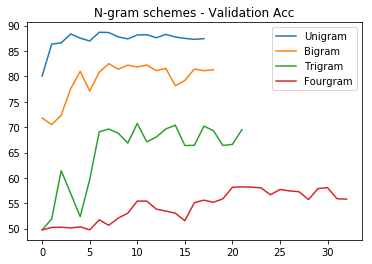

In [169]:
plt.plot(val_acc_n1)
plt.plot(val_acc_n2)
plt.plot(val_acc_n3)
plt.plot(val_acc_n4)
plt.title('N-gram schemes - Validation Acc')
plt.legend(['Unigram', 'Bigram', 'Trigram', 'Fourgram'], loc='upper right')
#plt.show()
plt.savefig('Assignment_1/training_curve_ngrams.jpg')

### Unigram outperforms 2-4 N-grams probably due to the nature of the binary classification task where positive words are likely linked to positive review. Using unigram from now on.

## 3. Vocabulary size 

### a. 5000

In [98]:
def tokenize_dataset(dataset, n = 1):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        stop_words = set(stopwords.words('english')) 
        tokens = [w for w in tokens if not w in stop_words] 
        if n > 1:
            ngrams_gn = ngrams(tokens, n)
            tokens = []
            for gram in ngrams_gn:
                tokens.append(gram)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_data)
# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
#     if rm_stopwords:
#         stop_words = set(stopwords.words('english')) 
#         all_tokens = [w for w in all_tokens if not w in stop_words] 
#     if lemmatize:
#         lmtzr = WordNetLemmatizer()
#         all_tokens = [lmtzr.lemmatize(w) for w in all_tokens]
#     if stem:
#         ps = PorterStemmer()
#         all_tokens = [ps.stem(w) for w in all_tokens]
#     if n > 1:
#         all_tokens = ngrams(all_tokens, n)
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 5000)

train_data_indices = token2index_dataset(train_data_tokens, token2id_map = token2id)
val_data_indices = token2index_dataset(val_data_tokens, token2id_map = token2id)

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_5k = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_5k.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Vocabulary size: 5000 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.7321062088012695, Val Loss: 2.3889167308807373, Val Acc: 81.5900421602088
Epoch: [1/10], Step: [201/623], Train Loss: 0.56125408411026, Val Loss: 2.296505928039551, Val Acc: 85.54507127082915
Epoch: [1/10], Step: [301/623], Train Loss: 0.48898589611053467, Val Loss: 2.2715840339660645, Val Acc: 86.66934350532021
Epoch: [1/10], Step: [401/623], Train Loss: 0.44337064027786255, Val Loss: 2.2644059658050537, Val Acc: 86.68941979522184
Epoch: [1/10], Step: [501/623], Train Loss: 0.4157082736492157, Val Loss: 2.2547972202301025, Val Acc: 87.1913270427625
Epoch: [1/10], Step: [601/623], Train Loss: 0.3992776870727539, Val Loss: 2.2593066692352295, Val Acc: 86.78980124472997
Epoch: [1/10], Train Acc: 91.53741906339407
Epoch: [2/10], Step: [101/623], Train Loss: 0.223252072930336, Val Loss: 2.240558624267578, Val Acc: 87.63300542059828
Epoch: [2/10], Step: [201/623], Train Loss: 0.22885841131210327, Val Loss: 2.2367727756500244, Val Acc: 87.7735394

### b. 10000

In [99]:
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 10000)

train_data_indices = token2index_dataset(train_data_tokens, token2id_map = token2id)
val_data_indices = token2index_dataset(val_data_tokens, token2id_map = token2id)

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_10k = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_10k.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Vocabulary size: 10000 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.7739497423171997, Val Loss: 2.382624626159668, Val Acc: 81.30897410158603
Epoch: [1/10], Step: [201/623], Train Loss: 0.5694124698638916, Val Loss: 2.278719663619995, Val Acc: 86.85003011443486
Epoch: [1/10], Step: [301/623], Train Loss: 0.4913446307182312, Val Loss: 2.2656798362731934, Val Acc: 87.07086930335274
Epoch: [1/10], Step: [401/623], Train Loss: 0.44541850686073303, Val Loss: 2.2531917095184326, Val Acc: 87.43224252158201
Epoch: [1/10], Step: [501/623], Train Loss: 0.41131487488746643, Val Loss: 2.239922046661377, Val Acc: 88.75727765508934
Epoch: [1/10], Step: [601/623], Train Loss: 0.393562912940979, Val Loss: 2.2424280643463135, Val Acc: 88.75727765508934
Epoch: [1/10], Train Acc: 94.36831802439391
Epoch: [2/10], Step: [101/623], Train Loss: 0.1839006096124649, Val Loss: 2.2298169136047363, Val Acc: 88.23529411764706
Epoch: [2/10], Step: [201/623], Train Loss: 0.16838745772838593, Val Loss: 2.2188570499420166, Val Acc: 88.6368

### c. 20000

In [100]:
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 20000)

train_data_indices = token2index_dataset(train_data_tokens, token2id_map = token2id)
val_data_indices = token2index_dataset(val_data_tokens, token2id_map = token2id)

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_20k = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_20k.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Vocabulary size: 5000 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.8178815841674805, Val Loss: 2.3857476711273193, Val Acc: 81.14836378237301
Epoch: [1/10], Step: [201/623], Train Loss: 0.5866197943687439, Val Loss: 2.2788734436035156, Val Acc: 85.76591045974703
Epoch: [1/10], Step: [301/623], Train Loss: 0.5026383399963379, Val Loss: 2.2585244178771973, Val Acc: 88.55651475607307
Epoch: [1/10], Step: [401/623], Train Loss: 0.45770734548568726, Val Loss: 2.2469608783721924, Val Acc: 89.29933748243324
Epoch: [1/10], Step: [501/623], Train Loss: 0.42349937558174133, Val Loss: 2.2354540824890137, Val Acc: 89.25918490263
Epoch: [1/10], Step: [601/623], Train Loss: 0.4017529785633087, Val Loss: 2.2363617420196533, Val Acc: 89.27926119253162
Epoch: [1/10], Train Acc: 95.11117803543642
Epoch: [2/10], Step: [101/623], Train Loss: 0.14968909323215485, Val Loss: 2.218065023422241, Val Acc: 89.60048183095763
Epoch: [2/10], Step: [201/623], Train Loss: 0.14594332873821259, Val Loss: 2.2186381816864014, Val Acc: 89.198

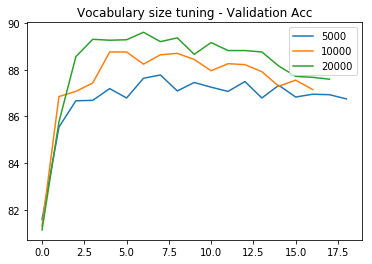

In [170]:
plt.plot(val_acc_5k)
plt.plot(val_acc_10k)
plt.plot(val_acc_20k)
plt.title('Vocabulary size tuning - Validation Acc')
plt.legend(['5000', '10000', '20000'], loc='upper right')
#plt.show()
plt.savefig('Assignment_1/training_curve_vocabsize.jpg')

### Vocabulary size of 20K outperforms 10K by a small margin and 5K. Using 20K from now on.

## 4. Embedding size

### a. 50

In [106]:
# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_data)
# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
#     if rm_stopwords:
#         stop_words = set(stopwords.words('english')) 
#         all_tokens = [w for w in all_tokens if not w in stop_words] 
#     if lemmatize:
#         lmtzr = WordNetLemmatizer()
#         all_tokens = [lmtzr.lemmatize(w) for w in all_tokens]
#     if stem:
#         ps = PorterStemmer()
#         all_tokens = [ps.stem(w) for w in all_tokens]
#     if n > 1:
#         all_tokens = ngrams(all_tokens, n)
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 20000)

train_data_indices = token2index_dataset(train_data_tokens, token2id_map = token2id)
val_data_indices = token2index_dataset(val_data_tokens, token2id_map = token2id)

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_50 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_50.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Embedding size: 50 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.9647859334945679, Val Loss: 2.446251630783081, Val Acc: 78.77936157398113
Epoch: [1/10], Step: [201/623], Train Loss: 0.6910555362701416, Val Loss: 2.3025712966918945, Val Acc: 86.22766512748444
Epoch: [1/10], Step: [301/623], Train Loss: 0.5670194625854492, Val Loss: 2.26542067527771, Val Acc: 87.45231881148364
Epoch: [1/10], Step: [401/623], Train Loss: 0.5064772963523865, Val Loss: 2.252769708633423, Val Acc: 88.05460750853243
Epoch: [1/10], Step: [501/623], Train Loss: 0.4633772671222687, Val Loss: 2.241203784942627, Val Acc: 88.89781168440072
Epoch: [1/10], Step: [601/623], Train Loss: 0.43192681670188904, Val Loss: 2.233466625213623, Val Acc: 89.52017667135114
Epoch: [1/10], Train Acc: 94.92044370827686
Epoch: [2/10], Step: [101/623], Train Loss: 0.1563727706670761, Val Loss: 2.2226510047912598, Val Acc: 89.58040554105601
Epoch: [2/10], Step: [201/623], Train Loss: 0.15276536345481873, Val Loss: 2.2178306579589844, Val Acc: 89.1186508

### b. 100

In [107]:
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_100 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_100.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Embedding size: 100 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.8266407251358032, Val Loss: 2.3817405700683594, Val Acc: 83.85866291909255
Epoch: [1/10], Step: [201/623], Train Loss: 0.5869506597518921, Val Loss: 2.271872043609619, Val Acc: 87.45231881148364
Epoch: [1/10], Step: [301/623], Train Loss: 0.4989827871322632, Val Loss: 2.254636287689209, Val Acc: 88.05460750853243
Epoch: [1/10], Step: [401/623], Train Loss: 0.4516891837120056, Val Loss: 2.2437167167663574, Val Acc: 88.95804055410561
Epoch: [1/10], Step: [501/623], Train Loss: 0.41880297660827637, Val Loss: 2.238386631011963, Val Acc: 89.15880345312186
Epoch: [1/10], Step: [601/623], Train Loss: 0.3984505534172058, Val Loss: 2.2399024963378906, Val Acc: 89.23910861272837
Epoch: [1/10], Train Acc: 95.85905737087788
Epoch: [2/10], Step: [101/623], Train Loss: 0.14840933680534363, Val Loss: 2.2228729724884033, Val Acc: 89.11865087331861
Epoch: [2/10], Step: [201/623], Train Loss: 0.14452499151229858, Val Loss: 2.2160263061523438, Val Acc: 88.897

### c. 200

In [108]:
emb_dim = 200
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_200 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_200.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Embedding size: 200 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.6745443940162659, Val Loss: 2.3205745220184326, Val Acc: 83.8988154988958
Epoch: [1/10], Step: [201/623], Train Loss: 0.5088608264923096, Val Loss: 2.268181324005127, Val Acc: 86.93033527404135
Epoch: [1/10], Step: [301/623], Train Loss: 0.44860270619392395, Val Loss: 2.252514600753784, Val Acc: 87.6530817104999
Epoch: [1/10], Step: [401/623], Train Loss: 0.410873681306839, Val Loss: 2.2482879161834717, Val Acc: 87.6530817104999
Epoch: [1/10], Step: [501/623], Train Loss: 0.38457000255584717, Val Loss: 2.2381114959716797, Val Acc: 88.29552298735194
Epoch: [1/10], Step: [601/623], Train Loss: 0.37160301208496094, Val Loss: 2.2446820735931396, Val Acc: 87.93414976912267
Epoch: [1/10], Train Acc: 95.50268533855343
Epoch: [2/10], Step: [101/623], Train Loss: 0.1339179277420044, Val Loss: 2.216309070587158, Val Acc: 88.79743023489259
Epoch: [2/10], Step: [201/623], Train Loss: 0.1401384323835373, Val Loss: 2.223104476928711, Val Acc: 87.97430234

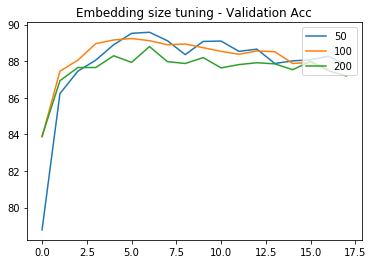

In [171]:
plt.plot(val_acc_50)
plt.plot(val_acc_100)
plt.plot(val_acc_200)
plt.title('Embedding size tuning - Validation Acc')
plt.legend(['50', '100', '200'], loc='upper right')
#plt.show()
plt.savefig('Assignment_1/training_curve_embedsize.jpg')

### Embedding size of 50 slightly outperforms 100 and 200. Although the performance of embedding size of 100 is slightly lower than 3.c. To be consistent, embedding size of 50 will be used from now on.

## 5. Sentence length

### a. 100

In [110]:
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
#     if rm_stopwords:
#         stop_words = set(stopwords.words('english')) 
#         all_tokens = [w for w in all_tokens if not w in stop_words] 
#     if lemmatize:
#         lmtzr = WordNetLemmatizer()
#         all_tokens = [lmtzr.lemmatize(w) for w in all_tokens]
#     if stem:
#         ps = PorterStemmer()
#         all_tokens = [ps.stem(w) for w in all_tokens]
#     if n > 1:
#         all_tokens = ngrams(all_tokens, n)
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 20000)

train_data_indices = token2index_dataset(train_data_tokens, token2id_map = token2id)
val_data_indices = token2index_dataset(val_data_tokens, token2id_map = token2id)

MAX_SENTENCE_LENGTH = 100

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_sl100 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_sl100.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Max sentence length: 100 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 1.0119531154632568, Val Loss: 2.464231491088867, Val Acc: 76.9925717727364
Epoch: [1/10], Step: [201/623], Train Loss: 0.7320461273193359, Val Loss: 2.3289899826049805, Val Acc: 83.69805259987955
Epoch: [1/10], Step: [301/623], Train Loss: 0.6097546219825745, Val Loss: 2.285020589828491, Val Acc: 85.78598674964867
Epoch: [1/10], Step: [401/623], Train Loss: 0.5411535501480103, Val Loss: 2.270019054412842, Val Acc: 86.4284280265007
Epoch: [1/10], Step: [501/623], Train Loss: 0.49606838822364807, Val Loss: 2.265040874481201, Val Acc: 86.87010640433648
Epoch: [1/10], Step: [601/623], Train Loss: 0.46678975224494934, Val Loss: 2.2604024410247803, Val Acc: 87.17125075286087
Epoch: [1/10], Train Acc: 94.11735180444713
Epoch: [2/10], Step: [101/623], Train Loss: 0.18623584508895874, Val Loss: 2.2438957691192627, Val Acc: 87.45231881148364
Epoch: [2/10], Step: [201/623], Train Loss: 0.18079297244548798, Val Loss: 2.2398881912231445, Val Acc: 87.47239

### b. 200

In [111]:
MAX_SENTENCE_LENGTH = 200

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_sl200 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_sl200.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Max sentence length: 200 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.9876643419265747, Val Loss: 2.452660083770752, Val Acc: 77.95623368801445
Epoch: [1/10], Step: [201/623], Train Loss: 0.7087804675102234, Val Loss: 2.311063528060913, Val Acc: 85.9666733587633
Epoch: [1/10], Step: [301/623], Train Loss: 0.5798584818840027, Val Loss: 2.2650294303894043, Val Acc: 87.83376831961453
Epoch: [1/10], Step: [401/623], Train Loss: 0.512056291103363, Val Loss: 2.252634048461914, Val Acc: 88.45613330656495
Epoch: [1/10], Step: [501/623], Train Loss: 0.46955904364585876, Val Loss: 2.246859312057495, Val Acc: 88.8777353944991
Epoch: [1/10], Step: [601/623], Train Loss: 0.4383469223976135, Val Loss: 2.238823890686035, Val Acc: 89.3394900622365
Epoch: [1/10], Train Acc: 94.88028911308538
Epoch: [2/10], Step: [101/623], Train Loss: 0.15114255249500275, Val Loss: 2.2255375385284424, Val Acc: 88.69704878538447
Epoch: [2/10], Step: [201/623], Train Loss: 0.14917483925819397, Val Loss: 2.219890832901001, Val Acc: 88.6970487853

### c. 300

In [112]:
MAX_SENTENCE_LENGTH = 300

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_sl300 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_sl300.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Max sentence length: 300 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.974026083946228, Val Loss: 2.468712091445923, Val Acc: 79.54226059024292
Epoch: [1/10], Step: [201/623], Train Loss: 0.6973989009857178, Val Loss: 2.307241201400757, Val Acc: 85.2037743425015
Epoch: [1/10], Step: [301/623], Train Loss: 0.5751442909240723, Val Loss: 2.268345355987549, Val Acc: 87.47239510138526
Epoch: [1/10], Step: [401/623], Train Loss: 0.5032266974449158, Val Loss: 2.246661424636841, Val Acc: 88.53643846617145
Epoch: [1/10], Step: [501/623], Train Loss: 0.4583907723426819, Val Loss: 2.235736846923828, Val Acc: 89.3394900622365
Epoch: [1/10], Step: [601/623], Train Loss: 0.42950743436813354, Val Loss: 2.2346317768096924, Val Acc: 89.19895603292511
Epoch: [1/10], Train Acc: 94.51387843196306
Epoch: [2/10], Step: [101/623], Train Loss: 0.1499275118112564, Val Loss: 2.222388982772827, Val Acc: 89.35956635213813
Epoch: [2/10], Step: [201/623], Train Loss: 0.14635641872882843, Val Loss: 2.2159221172332764, Val Acc: 89.4599478016

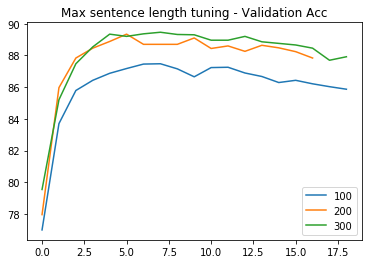

In [172]:
plt.plot(val_acc_sl100)
plt.plot(val_acc_sl200)
plt.plot(val_acc_sl300)
plt.title('Max sentence length tuning - Validation Acc')
plt.legend(['100', '200', '300'], loc='lower right')
# plt.show()
plt.savefig('Assignment_1/training_curve_maxlen.jpg')

### Max sentence length of 300 slightly outperforms 200 and 100. Using max sentence length of 300 from now on.

## 6. Optimizer

### a. Adam

In [115]:
MAX_SENTENCE_LENGTH = 300

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_adam = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_adam.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Optimizer: Adam - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/10], Step: [101/623], Train Loss: 0.9400739669799805, Val Loss: 2.4341659545898438, Val Acc: 77.4543264404738
Epoch: [1/10], Step: [201/623], Train Loss: 0.6731591820716858, Val Loss: 2.301665782928467, Val Acc: 85.18369805259988
Epoch: [1/10], Step: [301/623], Train Loss: 0.559447705745697, Val Loss: 2.2673938274383545, Val Acc: 86.60911463561534
Epoch: [1/10], Step: [401/623], Train Loss: 0.4938570261001587, Val Loss: 2.248746395111084, Val Acc: 87.99437863882754
Epoch: [1/10], Step: [501/623], Train Loss: 0.45787709951400757, Val Loss: 2.252855062484741, Val Acc: 87.83376831961453
Epoch: [1/10], Step: [601/623], Train Loss: 0.4292944371700287, Val Loss: 2.2383973598480225, Val Acc: 89.17887974302349
Epoch: [1/10], Train Acc: 95.13125533303217
Epoch: [2/10], Step: [101/623], Train Loss: 0.15937727689743042, Val Loss: 2.225712776184082, Val Acc: 89.21903232282673
Epoch: [2/10], Step: [201/623], Train Loss: 0.15636664628982544, Val Loss: 2.2194085121154785, Val Acc: 89.018269

### b. SGD

In [120]:
emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_sgd = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_sgd.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Optimizer: SGD - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/20], Step: [101/623], Train Loss: 2.6699931621551514, Val Loss: 2.9559168815612793, Val Acc: 50.6926320016061
Epoch: [1/20], Step: [201/623], Train Loss: 2.4452199935913086, Val Loss: 2.9107539653778076, Val Acc: 52.61995583216222
Epoch: [1/20], Step: [301/623], Train Loss: 2.2490530014038086, Val Loss: 2.861114263534546, Val Acc: 56.25376430435656
Epoch: [1/20], Step: [401/623], Train Loss: 2.083353281021118, Val Loss: 2.813612699508667, Val Acc: 55.711704477012645
Epoch: [1/20], Step: [501/623], Train Loss: 1.9440057277679443, Val Loss: 2.772538185119629, Val Acc: 56.71551897209396
Epoch: [1/20], Step: [601/623], Train Loss: 1.827386498451233, Val Loss: 2.738725423812866, Val Acc: 56.81590042160209
Epoch: [1/20], Train Acc: 57.345781257842695
Epoch: [2/20], Step: [101/623], Train Loss: 1.1207168102264404, Val Loss: 2.706164598464966, Val Acc: 58.783376831961455
Epoch: [2/20], Step: [201/623], Train Loss: 1.0851044654846191, Val Loss: 2.6854865550994873, Val Acc: 59.26520778

Epoch: [11/20], Step: [601/623], Train Loss: 0.6808881163597107, Val Loss: 2.5469400882720947, Val Acc: 62.4974904637623
Epoch: [11/20], Train Acc: 63.10796566782111
Epoch: [12/20], Step: [101/623], Train Loss: 0.6770086288452148, Val Loss: 2.546562671661377, Val Acc: 62.4974904637623
Epoch: [12/20], Step: [201/623], Train Loss: 0.6780239343643188, Val Loss: 2.5460925102233887, Val Acc: 62.27665127484441
Epoch: [12/20], Step: [301/623], Train Loss: 0.6774070858955383, Val Loss: 2.545693874359131, Val Acc: 62.356956434450915
Epoch: [12/20], Step: [401/623], Train Loss: 0.678369402885437, Val Loss: 2.545280933380127, Val Acc: 62.5777956233688
Epoch: [12/20], Step: [501/623], Train Loss: 0.6774892807006836, Val Loss: 2.544933557510376, Val Acc: 62.71832965268018
Epoch: [12/20], Step: [601/623], Train Loss: 0.6769669055938721, Val Loss: 2.544534206390381, Val Acc: 62.71832965268018
Epoch: [12/20], Train Acc: 63.25854539978919
Epoch: [13/20], Step: [101/623], Train Loss: 0.6765989661216736,

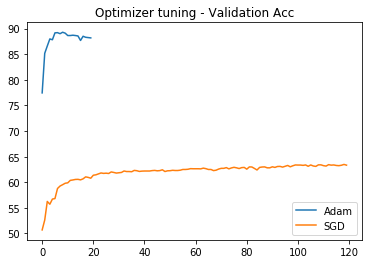

In [173]:
plt.plot(val_acc_adam)
plt.plot(val_acc_sgd)
plt.title('Optimizer tuning - Validation Acc')
plt.legend(['Adam', 'SGD'], loc='lower right')
# plt.show()
plt.savefig('Assignment_1/training_curve_opt.jpg')

### Optimizer Adam outperforms SGD in the first 20 epoches. The learning curve of SGD flattens after epoch 3. Using Adam from now on.

## 7. Learning rate

### a. constant 0.01

In [134]:
emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_lr01 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_lr01.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Learning rate: 0.01 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/20], Step: [101/623], Train Loss: 0.955021858215332, Val Loss: 2.4586009979248047, Val Acc: 77.59486046978519
Epoch: [1/20], Step: [201/623], Train Loss: 0.6930336356163025, Val Loss: 2.3105239868164062, Val Acc: 85.74583416984541
Epoch: [1/20], Step: [301/623], Train Loss: 0.5709260702133179, Val Loss: 2.2677316665649414, Val Acc: 87.61292913069664
Epoch: [1/20], Step: [401/623], Train Loss: 0.5068856477737427, Val Loss: 2.2488317489624023, Val Acc: 88.67697249548283
Epoch: [1/20], Step: [501/623], Train Loss: 0.4617069363594055, Val Loss: 2.237438917160034, Val Acc: 88.97811684400723
Epoch: [1/20], Step: [601/623], Train Loss: 0.4335377812385559, Val Loss: 2.234494686126709, Val Acc: 89.60048183095763
Epoch: [1/20], Train Acc: 95.02083019625559
Epoch: [2/20], Step: [101/623], Train Loss: 0.15438780188560486, Val Loss: 2.2238731384277344, Val Acc: 88.95804055410561
Epoch: [2/20], Step: [201/623], Train Loss: 0.15804074704647064, Val Loss: 2.2169713973999023, Val Acc: 89.0584

### b. constant 0.001

In [135]:
emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.001
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_lr001 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_lr001.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Learning rate: 0.001 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/20], Step: [101/623], Train Loss: 2.6216535568237305, Val Loss: 2.910858631134033, Val Acc: 49.98996185504919
Epoch: [1/20], Step: [201/623], Train Loss: 2.0189640522003174, Val Loss: 2.6594908237457275, Val Acc: 50.31118249347521
Epoch: [1/20], Step: [301/623], Train Loss: 1.6238374710083008, Val Loss: 2.5841898918151855, Val Acc: 60.16864083517366
Epoch: [1/20], Step: [401/623], Train Loss: 1.4002329111099243, Val Loss: 2.5607619285583496, Val Acc: 63.561533828548484
Epoch: [1/20], Step: [501/623], Train Loss: 1.258457064628601, Val Loss: 2.545056104660034, Val Acc: 69.80525998795423
Epoch: [1/20], Step: [601/623], Train Loss: 1.1584316492080688, Val Loss: 2.528850793838501, Val Acc: 73.6197550692632
Epoch: [1/20], Train Acc: 75.38021382321939
Epoch: [2/20], Step: [101/623], Train Loss: 0.6157978773117065, Val Loss: 2.5049095153808594, Val Acc: 76.28990162617949
Epoch: [2/20], Step: [201/623], Train Loss: 0.5952032804489136, Val Loss: 2.482261896133423, Val Acc: 78.31760690

Epoch: [11/20], Step: [601/623], Train Loss: 0.0917932540178299, Val Loss: 2.2123425006866455, Val Acc: 89.419795221843
Epoch: [11/20], Train Acc: 98.26331375796818
Epoch: [12/20], Step: [101/623], Train Loss: 0.07840949296951294, Val Loss: 2.211923837661743, Val Acc: 89.72093957036739
Epoch: [12/20], Step: [201/623], Train Loss: 0.07794946432113647, Val Loss: 2.211240768432617, Val Acc: 89.76109215017065
Epoch: [12/20], Step: [301/623], Train Loss: 0.079647496342659, Val Loss: 2.2112905979156494, Val Acc: 89.78116844007228
Epoch: [12/20], Step: [401/623], Train Loss: 0.07898058742284775, Val Loss: 2.2107186317443848, Val Acc: 89.66071070066252
Epoch: [12/20], Step: [501/623], Train Loss: 0.07877819240093231, Val Loss: 2.210475444793701, Val Acc: 89.62055812085927
Epoch: [12/20], Step: [601/623], Train Loss: 0.07883724570274353, Val Loss: 2.21016788482666, Val Acc: 89.58040554105601
Epoch: [12/20], Train Acc: 98.6999949806756
Epoch: [13/20], Step: [101/623], Train Loss: 0.0636853203177

### c. constant 0.0001

In [136]:
emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.0001
num_epochs = 50 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_lr0001 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_lr0001.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))

print('Learning rate: 0.0001 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/50], Step: [101/623], Train Loss: 2.9809176921844482, Val Loss: 2.992307662963867, Val Acc: 20.21682393093756
Epoch: [1/50], Step: [201/623], Train Loss: 2.9429097175598145, Val Loss: 2.9876184463500977, Val Acc: 33.26641236699458
Epoch: [1/50], Step: [301/623], Train Loss: 2.9032437801361084, Val Loss: 2.981966018676758, Val Acc: 42.64203975105401
Epoch: [1/50], Step: [401/623], Train Loss: 2.8609225749969482, Val Loss: 2.974994421005249, Val Acc: 47.52057819714917
Epoch: [1/50], Step: [501/623], Train Loss: 2.8143887519836426, Val Loss: 2.966266393661499, Val Acc: 49.46797831760691
Epoch: [1/50], Step: [601/623], Train Loss: 2.763838052749634, Val Loss: 2.9554481506347656, Val Acc: 50.31118249347521
Epoch: [1/50], Train Acc: 50.248456557747325
Epoch: [2/50], Step: [101/623], Train Loss: 2.357910633087158, Val Loss: 2.9387550354003906, Val Acc: 50.93354748042562
Epoch: [2/50], Step: [201/623], Train Loss: 2.288923501968384, Val Loss: 2.9219934940338135, Val Acc: 51.033928929

Epoch: [11/50], Step: [601/623], Train Loss: 0.6132062673568726, Val Loss: 2.5087170600891113, Val Acc: 76.30997791608111
Epoch: [11/50], Train Acc: 78.35667319178839
Epoch: [12/50], Step: [101/623], Train Loss: 0.6014927625656128, Val Loss: 2.5060501098632812, Val Acc: 76.530817104999
Epoch: [12/50], Step: [201/623], Train Loss: 0.5982723832130432, Val Loss: 2.5038349628448486, Val Acc: 77.11302951214616
Epoch: [12/50], Step: [301/623], Train Loss: 0.5965666174888611, Val Loss: 2.501556873321533, Val Acc: 77.33386870106405
Epoch: [12/50], Step: [401/623], Train Loss: 0.5936993956565857, Val Loss: 2.499162435531616, Val Acc: 77.5346316000803
Epoch: [12/50], Step: [501/623], Train Loss: 0.5912473201751709, Val Loss: 2.4968206882476807, Val Acc: 77.79562336880144
Epoch: [12/50], Step: [601/623], Train Loss: 0.5893024802207947, Val Loss: 2.494474411010742, Val Acc: 77.35394499096567
Epoch: [12/50], Train Acc: 79.797219294283
Epoch: [13/50], Step: [101/623], Train Loss: 0.5797699093818665,

Epoch: [22/50], Step: [401/623], Train Loss: 0.3732931613922119, Val Loss: 2.356921434402466, Val Acc: 84.60148564545273
Epoch: [22/50], Step: [501/623], Train Loss: 0.3711322247982025, Val Loss: 2.3551390171051025, Val Acc: 84.58140935555109
Epoch: [22/50], Step: [601/623], Train Loss: 0.37115058302879333, Val Loss: 2.3534843921661377, Val Acc: 84.68179080505922
Epoch: [22/50], Train Acc: 87.19570345831451
Epoch: [23/50], Step: [101/623], Train Loss: 0.3572979271411896, Val Loss: 2.3514978885650635, Val Acc: 84.78217225456736
Epoch: [23/50], Step: [201/623], Train Loss: 0.3559482991695404, Val Loss: 2.350188732147217, Val Acc: 84.88255370407549
Epoch: [23/50], Step: [301/623], Train Loss: 0.3586055040359497, Val Loss: 2.3486456871032715, Val Acc: 84.98293515358361
Epoch: [23/50], Step: [401/623], Train Loss: 0.3588724732398987, Val Loss: 2.347038745880127, Val Acc: 85.02308773338687
Epoch: [23/50], Step: [501/623], Train Loss: 0.3590664267539978, Val Loss: 2.3455870151519775, Val Acc:

Epoch: [33/50], Step: [201/623], Train Loss: 0.2657370865345001, Val Loss: 2.28775954246521, Val Acc: 87.17125075286087
Epoch: [33/50], Step: [301/623], Train Loss: 0.2713002860546112, Val Loss: 2.2875092029571533, Val Acc: 87.13109817305762
Epoch: [33/50], Step: [401/623], Train Loss: 0.27038782835006714, Val Loss: 2.2868053913116455, Val Acc: 87.21140333266412
Epoch: [33/50], Step: [501/623], Train Loss: 0.271836519241333, Val Loss: 2.286101818084717, Val Acc: 87.17125075286087
Epoch: [33/50], Step: [601/623], Train Loss: 0.2712031900882721, Val Loss: 2.2857203483581543, Val Acc: 87.25155591246738
Epoch: [33/50], Train Acc: 90.44822566882497
Epoch: [34/50], Step: [101/623], Train Loss: 0.2605854272842407, Val Loss: 2.284736394882202, Val Acc: 87.23147962256574
Epoch: [34/50], Step: [201/623], Train Loss: 0.2633645832538605, Val Loss: 2.2841033935546875, Val Acc: 87.25155591246738
Epoch: [34/50], Step: [301/623], Train Loss: 0.26120492815971375, Val Loss: 2.28340220451355, Val Acc: 87

Epoch: [43/50], Step: [601/623], Train Loss: 0.22240012884140015, Val Loss: 2.257930278778076, Val Acc: 88.4962858863682
Epoch: [43/50], Train Acc: 92.29031772323445
Epoch: [44/50], Step: [101/623], Train Loss: 0.217281773686409, Val Loss: 2.2573163509368896, Val Acc: 88.55651475607307
Epoch: [44/50], Step: [201/623], Train Loss: 0.21584700047969818, Val Loss: 2.2571187019348145, Val Acc: 88.57659104597471
Epoch: [44/50], Step: [301/623], Train Loss: 0.21835611760616302, Val Loss: 2.2565388679504395, Val Acc: 88.57659104597471
Epoch: [44/50], Step: [401/623], Train Loss: 0.2160627841949463, Val Loss: 2.2562177181243896, Val Acc: 88.55651475607307
Epoch: [44/50], Step: [501/623], Train Loss: 0.2168601155281067, Val Loss: 2.256201982498169, Val Acc: 88.59666733587633
Epoch: [44/50], Step: [601/623], Train Loss: 0.21733862161636353, Val Loss: 2.2558276653289795, Val Acc: 88.57659104597471
Epoch: [44/50], Train Acc: 92.46097475279828
Epoch: [45/50], Step: [101/623], Train Loss: 0.215832114

### d. annealing from 0.01

In [137]:
emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.01
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_anneal = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_anneal.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Learning Rate: {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), learning_rate, np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
#                 if bad_iter >= 3:
#                     learning_rate /= 10
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))
    learning_rate /= 10

print('Learning rate: annealing from 0.01 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/20], Step: [101/623], Learning Rate: 0.01, Train Loss: 0.9195836782455444, Val Loss: 2.4403533935546875, Val Acc: 76.9925717727364
Epoch: [1/20], Step: [201/623], Learning Rate: 0.01, Train Loss: 0.6639795303344727, Val Loss: 2.2982096672058105, Val Acc: 86.64926721541859
Epoch: [1/20], Step: [301/623], Learning Rate: 0.01, Train Loss: 0.5570310354232788, Val Loss: 2.265956401824951, Val Acc: 88.09476008833568
Epoch: [1/20], Step: [401/623], Learning Rate: 0.01, Train Loss: 0.49263182282447815, Val Loss: 2.248666524887085, Val Acc: 89.05842200361373
Epoch: [1/20], Step: [501/623], Learning Rate: 0.01, Train Loss: 0.4499059021472931, Val Loss: 2.239427328109741, Val Acc: 89.07849829351535
Epoch: [1/20], Step: [601/623], Learning Rate: 0.01, Train Loss: 0.4208346903324127, Val Loss: 2.231264114379883, Val Acc: 89.27926119253162
Epoch: [1/20], Train Acc: 94.95557897906941
Epoch: [2/20], Step: [101/623], Learning Rate: 0.001, Train Loss: 0.15343880653381348, Val Loss: 2.220782041

### e. annealing from 0.001

In [142]:
emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.001
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_anneal2 = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_anneal2.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Learning Rate: {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), learning_rate, np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    checkpoint = {
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                    }
                    torch.save(checkpoint, 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
#                 if bad_iter >= 3:
#                     learning_rate /= 10
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))
    learning_rate /= 10

print('Learning rate: annealing from 0.001 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)


Epoch: [1/20], Step: [101/623], Learning Rate: 0.001, Train Loss: 2.5686779022216797, Val Loss: 2.9058191776275635, Val Acc: 54.14575386468581
Epoch: [1/20], Step: [201/623], Learning Rate: 0.001, Train Loss: 1.9776729345321655, Val Loss: 2.6565258502960205, Val Acc: 58.22124071471592
Epoch: [1/20], Step: [301/623], Learning Rate: 0.001, Train Loss: 1.594007134437561, Val Loss: 2.5815064907073975, Val Acc: 59.9678779361574
Epoch: [1/20], Step: [401/623], Learning Rate: 0.001, Train Loss: 1.3770161867141724, Val Loss: 2.5591492652893066, Val Acc: 67.23549488054607
Epoch: [1/20], Step: [501/623], Learning Rate: 0.001, Train Loss: 1.2391889095306396, Val Loss: 2.543131113052368, Val Acc: 68.11885163621763
Epoch: [1/20], Step: [601/623], Learning Rate: 0.001, Train Loss: 1.1419308185577393, Val Loss: 2.525670289993286, Val Acc: 73.88074683798435
Epoch: [1/20], Train Acc: 77.10686141645334
Epoch: [2/20], Step: [101/623], Learning Rate: 0.0001, Train Loss: 0.6032608151435852, Val Loss: 2.498

Epoch: [9/20], Step: [401/623], Learning Rate: 1.0000000000000003e-11, Train Loss: 0.12003212422132492, Val Loss: 2.2176501750946045, Val Acc: 89.86147359967877
Epoch: [9/20], Step: [501/623], Learning Rate: 1.0000000000000003e-11, Train Loss: 0.12127676606178284, Val Loss: 2.217550277709961, Val Acc: 89.84139730977715
Epoch: [9/20], Step: [601/623], Learning Rate: 1.0000000000000003e-11, Train Loss: 0.1202932596206665, Val Loss: 2.216719388961792, Val Acc: 89.84139730977715
Epoch: [9/20], Train Acc: 97.26446820257993
Epoch: [10/20], Step: [101/623], Learning Rate: 1.0000000000000002e-12, Train Loss: 0.0992848202586174, Val Loss: 2.2160398960113525, Val Acc: 90.00200762899016
Training stopped at epoch 10, iteration 101
Learning rate: annealing from 0.001 - Best Val Acc: 89.98193133908853


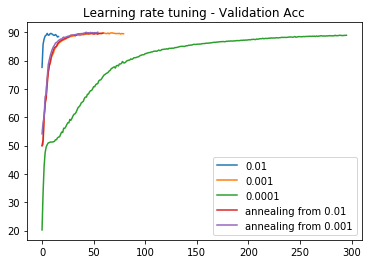

In [175]:
plt.plot(val_acc_lr01)
plt.plot(val_acc_lr001)
plt.plot(val_acc_lr0001)
plt.plot(val_acc_anneal)
plt.plot(val_acc_anneal2)
plt.title('Learning rate tuning - Validation Acc')
plt.legend(['0.01', '0.001', '0.0001', 'annealing from 0.01', 'annealing from 0.001'], loc='lower right')
# plt.show()
plt.savefig('Assignment_1/training_curve_lr.jpg')

### Annealing from 0.001 achieved best performance.

## Training using the best parameter set and evaluate on the test set

In [144]:
def tokenize_dataset(dataset, n = 1):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        stop_words = set(stopwords.words('english')) 
        tokens = [w for w in tokens if not w in stop_words] 
        if n > 1:
            ngrams_gn = ngrams(tokens, n)
            tokens = []
            for gram in ngrams_gn:
                tokens.append(gram)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(test_data_rmdup)
# pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))


train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
#     if rm_stopwords:
#         stop_words = set(stopwords.words('english')) 
#         all_tokens = [w for w in all_tokens if not w in stop_words] 
#     if lemmatize:
#         lmtzr = WordNetLemmatizer()
#         all_tokens = [lmtzr.lemmatize(w) for w in all_tokens]
#     if stem:
#         ps = PorterStemmer()
#         all_tokens = [ps.stem(w) for w in all_tokens]
#     if n > 1:
#         all_tokens = ngrams(all_tokens, n)
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 20000)

train_data_indices = token2index_dataset(train_data_tokens, token2id_map = token2id)
val_data_indices = token2index_dataset(val_data_tokens, token2id_map = token2id)
test_data_indices = token2index_dataset(test_data_tokens, token2id_map = token2id)

MAX_SENTENCE_LENGTH = 300

train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label_rmdup)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_collate_func,
                                           shuffle=True)

emb_dim = 50
model = BagOfWords(len(id2token), emb_dim)

learning_rate = 0.001
num_epochs = 50 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_acc_best = 0
val_acc_anneal = []
ep_iter_best = [0,0]
bad_iter = 0
break_flag = False
for epoch in range(num_epochs):
    train_loss = []
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.numpy())
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc, val_loss = test_model(val_loader, model)
            val_acc_anneal.append(val_acc)
#             test_acc, test_loss = test_model(test_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Learning Rate: {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), learning_rate, np.mean(train_loss), val_loss, val_acc))
            # early stopping patience = 10
            if bad_iter < 10:
                if val_acc >= val_acc_best:
                    val_acc_best = val_acc
                    ep_iter_best = [epoch+1, i+1]
                    bad_iter = 0
                    torch.save(model.state_dict(), 'Assignment_1/bow-epoch{}-iter{}'.format(epoch + 1, i+1))
                elif val_acc < val_acc_best:
                    bad_iter += 1
#                 if bad_iter >= 3:
#                     learning_rate /= 10
            elif bad_iter >= 10:
                print('Training stopped at epoch {}, iteration {}'.format(epoch+1, i+1))
                break_flag = True
                break
    if break_flag:
        break
    train_acc, train_loss = test_model(train_loader, model)
    print('Epoch: [{}/{}], Train Acc: {}'.format(epoch+1, num_epochs, train_acc))
    learning_rate /= 10

print('Learning rate: annealing from 0.001 - Best Val Acc: {}'.format(val_acc_best))
    #print(train_loss)
## load the best model
model = BagOfWords(len(id2token), emb_dim)
model.load_state_dict(torch.load('Assignment_1/bow-epoch{}-iter{}'.format(ep_iter_best[0], ep_iter_best[1])))
torch.save(model, 'Assignment_1/bow-epoch{}-iter{}_whole'.format(ep_iter_best[0], ep_iter_best[1]))

model = torch.load('Assignment_1/bow-epoch{}-iter{}_whole'.format(ep_iter_best[0], ep_iter_best[1]))
model.eval()
test_acc, _ = test_model(test_loader, model)
print('Test Acc: {}'.format(test_acc))

Train dataset size is 19923
Val dataset size is 4981
Test dataset size is 24678
Total number of tokens in train dataset is 2466030
Epoch: [1/50], Step: [101/623], Learning Rate: 0.001, Train Loss: 2.521371603012085, Val Loss: 2.8943724632263184, Val Acc: 49.92973298534431
Epoch: [1/50], Step: [201/623], Learning Rate: 0.001, Train Loss: 1.9363017082214355, Val Loss: 2.653021812438965, Val Acc: 51.9975908452118
Epoch: [1/50], Step: [301/623], Learning Rate: 0.001, Train Loss: 1.566598653793335, Val Loss: 2.5825133323669434, Val Acc: 60.02810680586228
Epoch: [1/50], Step: [401/623], Learning Rate: 0.001, Train Loss: 1.3574897050857544, Val Loss: 2.561321258544922, Val Acc: 65.00702670146556
Epoch: [1/50], Step: [501/623], Learning Rate: 0.001, Train Loss: 1.2241930961608887, Val Loss: 2.5463428497314453, Val Acc: 66.5729773137924
Epoch: [1/50], Step: [601/623], Learning Rate: 0.001, Train Loss: 1.1305886507034302, Val Loss: 2.530771017074585, Val Acc: 71.49166833969082
Epoch: [1/50], Tra

Epoch: [9/50], Step: [401/623], Learning Rate: 1.0000000000000003e-11, Train Loss: 0.12247323989868164, Val Loss: 2.220038414001465, Val Acc: 89.37964264203976
Epoch: [9/50], Step: [501/623], Learning Rate: 1.0000000000000003e-11, Train Loss: 0.1239626333117485, Val Loss: 2.219496965408325, Val Acc: 89.60048183095763
Epoch: [9/50], Step: [601/623], Learning Rate: 1.0000000000000003e-11, Train Loss: 0.124024897813797, Val Loss: 2.2187366485595703, Val Acc: 89.50010038144951
Epoch: [9/50], Train Acc: 97.03357928022888
Epoch: [10/50], Step: [101/623], Learning Rate: 1.0000000000000002e-12, Train Loss: 0.10223643481731415, Val Loss: 2.2187798023223877, Val Acc: 89.31941377233487
Epoch: [10/50], Step: [201/623], Learning Rate: 1.0000000000000002e-12, Train Loss: 0.09924912452697754, Val Loss: 2.2173407077789307, Val Acc: 89.6406344107609
Epoch: [10/50], Step: [301/623], Learning Rate: 1.0000000000000002e-12, Train Loss: 0.10283908247947693, Val Loss: 2.216705560684204, Val Acc: 89.520176671

/Users/Ji/anaconda3/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Test Acc: 87.470621606289


In [149]:
## extracting cases from val set
model = torch.load('Assignment_1/bow-epoch{}-iter{}_whole'.format(ep_iter_best[0], ep_iter_best[1]))
model.eval()
correct = 0
for data, lengths, labels in val_loader:
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(model(data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    correct += predicted.eq(labels.view_as(predicted)).sum().item()
    if correct >= 3 and len(data_batch) - correct >= 3:
        break
print(correct)

29


In [162]:
label_batch.eq(predicted.view_as(label_batch)).nonzero()
# correct: 0,1,2
# incorrect: 3,20,27

tensor([[ 0],
        [ 1],
        [ 2],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [19],
        [21],
        [22],
        [23],
        [24],
        [25],
        [26],
        [28],
        [29],
        [30],
        [31]])

In [163]:
train_all_token, _ = tokenize_dataset(train_data_all_rmdup)


In [178]:
train_all_indices = token2index_dataset(train_all_token, token2id_map = token2id)
train_all_dataset = NewsGroupDataset(train_all_indices, train_label_all_rmdup)


In [187]:
correct_idx = [0,1,2]
incorrect_idx = [3,20,27]
cor_data_idx = []
incor_data_idx = []
for i in correct_idx:
    for j in range(len(train_all_indices)):
        if np.array_equal(data_batch[i].data.numpy()[:len(train_all_indices[j])], train_all_indices[j]):
            cor_data_idx.append(j)

for i in incorrect_idx:
    for j in range(len(train_all_indices)):
        if np.array_equal(data_batch[i].data.numpy()[:len(train_all_indices[j])], train_all_indices[j]):
            incor_data_idx.append(j)

In [188]:
print(cor_data_idx)
print(incor_data_idx)

[4668, 824, 15788]
[15736, 21518, 12980]


In [191]:
for i in (cor_data_idx):
    print(train_data_all_rmdup[i])
    print(len(train_data_all_rmdup[i]))


I never heard of the book, nor care to read it, but the movie I will probably see many times. This film is unforgettable with perhaps the richest imagery I have ever seen in a movie. It was as if I was looking at paintings many times, which I think was the idea. Terrific movie, story, actors, and cinematography. Full of profound emotions from every angle. Although I am not particularly fond of romance movies, I loved this and was deeply moved by Winona Ryders plea to her father toward the end. Mr. Irons deserved an award for his performance and Close was never better. 
575
A trio of buddies, sergeants all in the British Army, carouse & brawl their way across Imperial India. Intensely loyal to each other, they meet their greatest & most deadly challenge when they encounter the resurgence of a hideous cult & its demented, implacable guru. Now they must rely on the lowliest servant of the regiment, the water carrier GUNGA DIN, to save scores of the Queens soldiers from certain massacre. B

In [193]:
print(len(data_batch[2]))

300


In [194]:
for i in (incor_data_idx):
    print(train_data_all_rmdup[i])
    print(len(train_data_all_rmdup[i]))


Although I am generally a proponent of the well-made film, I do not limit myself to films which escape those boundaries, and more often than not I do enjoy and admire films that successfully "break the rules." And it is quite true that director Pasolini breaks the rules of established cinema. But it is also my opinion that he does not break them successfully or to any actual point. Pasolinis work is visually jarring, but this is less a matter of what is actually on the screen than how it is filmed, and the jumpiness of his films seem less a matter of artistic choice than the result of amateur cinematography. This is true of DECAMERON. Pasolini often preferred to use non-actors, and while many directors have done so with remarkable result, under Pasolinis direction his non-actors tend to remain non-actors. This is also true of DECAMERON. Pasolini quite often includes images designed to shock, offend, or otherwise disconcert the audience. Such elements can often be used with startling ef